### Imports

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
from skimage.transform import resize
import ot
from sklearn import cluster
from tqdm import tqdm
import time

In [2]:
"""if torch.cuda.is_available():
    device='cuda'
    dtype = torch.cuda.DoubleTensor
else:
    device='cpu'
    dtype=torch.DoubleTensor
print(device)"""

device='cpu'
dtype=torch.DoubleTensor
torch.set_default_tensor_type(dtype)

In [3]:
import os
import sys
sys.path.append('../code/')

In [4]:
from utils_Color_Transfer import MK, monge
from SWGG import SWGG_CP_color,SWGG_CP,get_SWGG_smooth,SWGG_smooth
from utils import random_slice,sort_to_plan

## Image Loading and Quantization

In [57]:
source = img_as_ubyte(io.imread('data/Images/Colorization-Color Transfer/bridge.png'))
target = img_as_ubyte(io.imread('data/Images/Colorization-Color Transfer/mountain.png'))
#reshaped_target = img_as_ubyte(resize(target, source.shape[:2]))

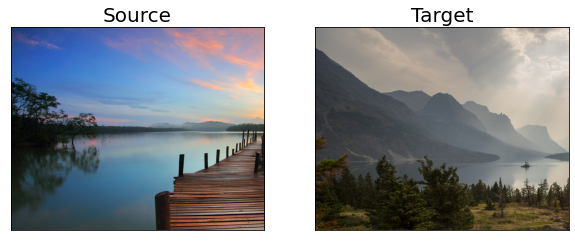

In [58]:
f, ax = plt.subplots(1, 2, figsize=(10, 10))


ax[0].imshow(source)
ax[1].imshow(target)

ax[0].set_title('Source', fontsize = 20)
ax[1].set_title('Target', fontsize=20)

for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)

f.patch.set_alpha(0)
    
plt.show()

In [120]:
X = torch.tensor(source.reshape((-1,3))).float()
Y = torch.tensor(target.reshape((-1,3))).float()

# SWGG random search

In [8]:
start_swgg = time.time()

n_proj=100
dim=3
theta_l=[random_slice(n_proj//10,dim).T for i in range(10)]

W_min=float('inf')
for theta in theta_l:
    W,u,v=SWGG_CP_color(X,Y,theta.float())
    if W<W_min:
        W_min=W
        u_min=u
        v_min=v



X[u]=Y[v]
end_swgg = time.time()
print(("SWGG OT ran in {}s").format(end_swgg - start_swgg))

SWGG OT ran in 8.821317911148071s


In [9]:
img_swgg_random=X.reshape(source.shape).numpy().astype(np.uint8)

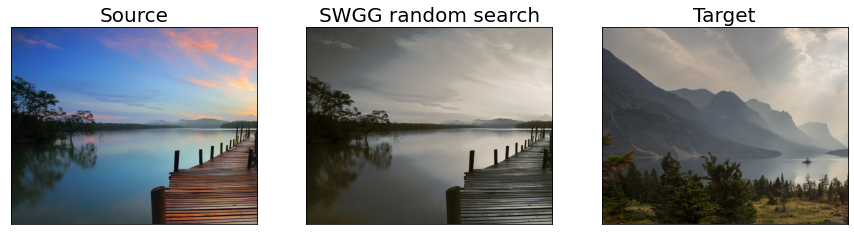

In [10]:
f, ax = plt.subplots(1, 3, figsize=(15, 10))


ax[0].imshow(source)
ax[1].imshow(img_swgg_random)
ax[2].imshow(target)

ax[0].set_title('Source', fontsize = 20)
ax[1].set_title('SWGG random search', fontsize = 20)
ax[2].set_title('Target', fontsize=20)

for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)

f.patch.set_alpha(0)
    
plt.show()

# SWGG Gradient descent

In [11]:
num_iter=10
lr=1e-1
s=2
std=1

start_swggopt = time.time()
theta,loss_smooth_l,proj_smooth_l = get_SWGG_smooth(X,Y,lr=lr,num_iter=num_iter,s=s,std=std)
theta.requires_grad=False
theta_optim=(theta/torch.norm(theta)).reshape((3,1))

end_swggopt = time.time()

_,u,v=SWGG_CP(X,Y,theta_optim)
X[u]=Y[v]
print(("SWGG OT ran in {}s").format(end_swggopt - start_swggopt))



  0%|                                                    | 0/10 [00:00<?, ?it/s]/home/gui/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|███████████████████████████| 10/10 [00:06<00:00,  1.53it/s, loss = 352.292]

SWGG OT ran in 6.554841995239258s


In [12]:
"""plt.figure(figsize=(8,3))
grid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)

plt.subplot(grid[0, 0])
plt.plot(loss_smooth_l)
plt.title('minSW smooth mass')

plt.subplot(grid[0, 1])
plt.scatter(X[:, 0], X[:, 1], c='C0', label='Source')
plt.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target')
for i in range(num_iter):
    plt.axline((0,0), list(proj_smooth_l[i,0:2]), color='C2',alpha=(i/num_iter)**1)"""


"plt.figure(figsize=(8,3))\ngrid = plt.GridSpec(1, 2, wspace=0.4, hspace=0.3)\n\nplt.subplot(grid[0, 0])\nplt.plot(loss_smooth_l)\nplt.title('minSW smooth mass')\n\nplt.subplot(grid[0, 1])\nplt.scatter(X[:, 0], X[:, 1], c='C0', label='Source')\nplt.scatter(Y[:, 0], Y[:, 1], c='C1', label='Target')\nfor i in range(num_iter):\n    plt.axline((0,0), list(proj_smooth_l[i,0:2]), color='C2',alpha=(i/num_iter)**1)"

In [13]:
img_swgg_optim=X.reshape(source.shape).numpy().astype(np.uint8)

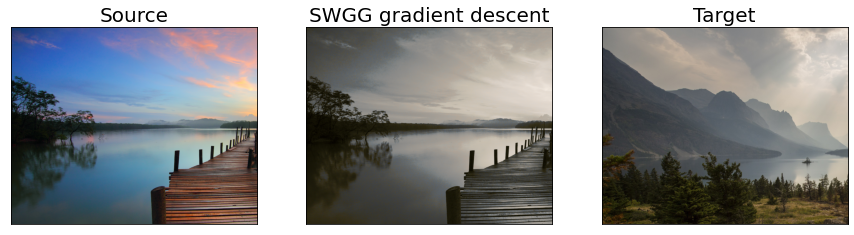

In [14]:
f, ax = plt.subplots(1, 3, figsize=(15, 10))


ax[0].imshow(source)
ax[1].imshow(img_swgg_optim)
ax[2].imshow(target)

ax[0].set_title('Source', fontsize = 20)
ax[1].set_title('SWGG gradient descent', fontsize = 20)
ax[2].set_title('Target', fontsize=20)

for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)

f.patch.set_alpha(0)
    
plt.show()

# Subspace Detour

In [130]:
gray_vec = torch.tensor([0.3, 0.59, 0.11]).float()

X_gray=torch.matmul(X,gray_vec).long()
Y_gray=torch.matmul(Y,gray_vec).long()

X_gray_sorted,_=torch.sort(X_gray)
Y_gray_sorted,_=torch.sort(Y_gray)

In [132]:
gamma_gray = {}

for i in range(len(X_gray_sorted)):
    #print(i,end=' ')
    if int(X_gray[X_gray_sorted[i]]) in gamma_gray:
        #print("ui")
        gamma_gray[int(X_gray[X_gray_sorted[i]])].append(gray_transport[i])
    else:
        gamma_gray[int(X_gray[X_gray_sorted[i]])] = [gray_transport[i]]
        


In [155]:
gray_transf = torch.zeros((X_gray.shape[0],3)).long()

for col in gamma_gray:
    #print(col)
    temp = torch.stack(gamma_gray[col])
    print(temp)
    x=temp[:,0]
    y=temp[:,1]
    #x=x.reshape(-1)
    #y=y.reshape(-1)
    #print(x,y)
    n = len(x)
    a = b = torch.ones(n) / n
    #dists = ((np.delete(s[x], c, 1)[:, None, :] - np.delete(t[y], c, 1))**2).sum(axis=2)
    dists = ((X[x][:, None, :] - Y[y])**2).sum(axis=2)
    #print(dists)
    #print(dists.shape)
    i, j = np.nonzero(ot.emd(a, b,dists).numpy())
    gray_transf[x[torch.tensor(i)]] = Y[y[torch.tensor(j)]].long()

tensor([[ 0,  0],
        [ 0,  0],
        [ 0,  0],
        ...,
        [59, 51],
        [59, 51],
        [59, 51]])


RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 44572978992 bytes. Error code 12 (Ne peut allouer de la mémoire)

In [156]:
"""img_subspace=(gray_transf.reshape(source.shape)).numpy().astype(np.uint8)
f, ax = plt.subplots(1, 3, figsize=(15, 10))


ax[0].imshow(source)
ax[1].imshow(img_subspace)
ax[2].imshow(target)

ax[0].set_title('Source', fontsize = 20)
ax[1].set_title('Subspace Detour', fontsize = 20)
ax[2].set_title('Target', fontsize=20)

for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)

f.patch.set_alpha(0)
    
plt.show()"""

"img_subspace=(gray_transf.reshape(source.shape)).numpy().astype(np.uint8)\nf, ax = plt.subplots(1, 3, figsize=(15, 10))\n\n\nax[0].imshow(source)\nax[1].imshow(img_subspace)\nax[2].imshow(target)\n\nax[0].set_title('Source', fontsize = 20)\nax[1].set_title('Subspace Detour', fontsize = 20)\nax[2].set_title('Target', fontsize=20)\n\nfor axis in ax:\n    axis.get_yaxis().set_visible(False)\n    axis.get_xaxis().set_visible(False)\n\nf.patch.set_alpha(0)\n    \nplt.show()"

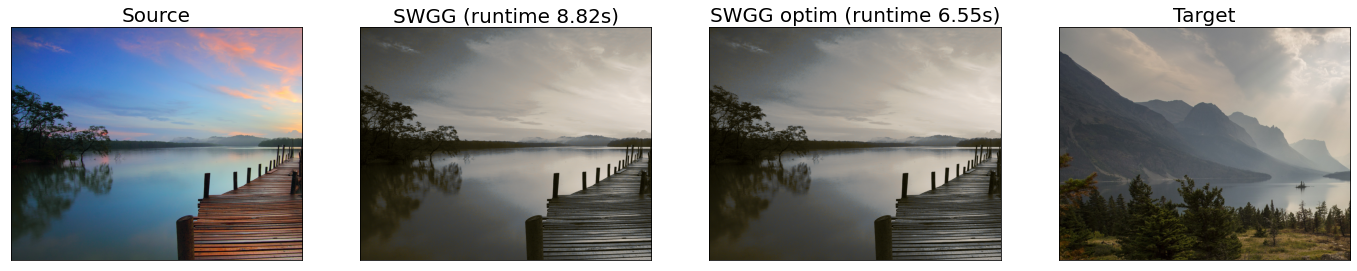

In [158]:
f, ax = plt.subplots(1, 4, figsize=(24, 6))

ax[0].imshow(source)
ax[1].imshow(img_swgg_optim)
ax[2].imshow(img_swgg_random)
ax[3].imshow(target)


"""
ax[0].set_title('Source', fontsize = 20)
ax[1].set_title('Full OT', fontsize = 20)
ax[2].set_title('SWGG' , fontsize = 20)
ax[4].set_title('Subspace Detour', fontsize = 20)
ax[3].set_title('SWGG optim', fontsize = 20)
#ax[4].set_title(('Factored Coupling (runtime {:.2f}s)').format(end_factored - start_factored), fontsize=20)
ax[5].set_title('Target', fontsize = 20)"""


ax[0].set_title('Source', fontsize = 20)
ax[1].set_title(('SWGG (runtime {:.2f}s)').format(end_swgg - start_swgg), fontsize = 20)
ax[2].set_title(('SWGG optim (runtime {:.2f}s)').format(end_swggopt - start_swggopt), fontsize = 20)
ax[3].set_title('Target', fontsize = 20)

for axis in ax:
    axis.get_yaxis().set_visible(False)
    axis.get_xaxis().set_visible(False)
    
plt.savefig("../Figure/Color_transfer_long_no_sub.png",bbox_inches='tight')    
plt.show()